In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from itertools import product
import logging
import pickle

In [2]:
#configure logging
# Reset any previous logging configuration
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Basic configuration to log to a file
logging.basicConfig(filename='../results/foundation_shade_log.txt', level=logging.INFO, format=' %(message)s')

logger = logging.getLogger()

In [3]:
#make a function to load the image using cv2
def load_image(image_path):
    try:
        logger.info(image_path + " loaded successfully")
        return cv2.imread(image_path)
    except:
        logger.info("Unable to load image")

In [7]:
#function for detecting faces in the image
def detect_face(image):

    #load the cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    #As it only works on grey images, convert the image to  greyscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Now detect faces in image
    #scale factor sets scale by which faces are detected
    #min size gives the minimum size that the face detected should be
    #haar cascades works by drawing rectangles for faces so min neighbours specifies minimum number of rectangles there should be
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    #now check if there are any faces detected
    if len(faces) == 0:
        return False
    else:
        #Select the largest face by getting max
        face_detected = max(faces, key=lambda rect: rect[2] * rect[3])  

        #get the x,y, width and height of the face
        x,y,h,w=face_detected

        #Crop the image to get the face
        face = image[y:y+h, x:x+w]

        #return the face
        return face
    

In [9]:
# Function to get the skin pixels from the image and return them in RGB
def get_skin_tone(image):
    # Convert the image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define minimum and maximum values for skin HSV
    lower_hsv = np.array([0, 40, 30], dtype=np.uint8)
    upper_hsv = np.array([25, 255, 255], dtype=np.uint8)
    
    # Create a mask to only get pixels in the specified range
    skin_mask = cv2.inRange(hsv_image, lower_hsv, upper_hsv)
    
    # Apply the mask to the image to detect skin pixels
    skin_pixels_bgr = cv2.bitwise_and(image, image, mask=skin_mask)
    
    # Convert skin pixels from BGR to RGB
    skin_pixels_rgb = cv2.cvtColor(skin_pixels_bgr, cv2.COLOR_BGR2RGB)

    return skin_pixels_rgb


In [11]:
#function to detect white areas in the image
def detect_white_areas(image):
    #Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    #Define thresholds for white areas
    lower_white = np.array([0, 0, 200], dtype=np.uint8)
    upper_white = np.array([180, 50, 255], dtype=np.uint8)

    #Create a mask for white areas
    white_mask = cv2.inRange(hsv_image, lower_white, upper_white)

    #Detect white areas in the image
    white_areas = cv2.bitwise_and(image, image, mask=white_mask)

    #Calculate the average color of the white areas
    non_zero_pixels = white_areas[white_mask == 255]
    if non_zero_pixels.size > 0:
        avg_color = np.mean(non_zero_pixels, axis=0)
    else:
        avg_color = [0, 0, 0]
        
    return avg_color

In [13]:
class ColorExtractionPipeline:
    def __init__(self, n_clusters=10):
        self.n_clusters = n_clusters  # Allow customization of the number of clusters

    def get_labels(self, pixels):
        # Apply KMeans clustering for color extraction
        clf = KMeans(n_clusters=self.n_clusters)
        labels = clf.fit_predict(pixels)
        return labels, clf

    def RGB2HEX(self, color):
        # Convert RGB color to HEX format
        return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

    def HEX2RGB(self, hex_color):
        # Convert HEX color to RGB format
        hex_color = hex_color.lstrip('#')
        rgb_color = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        return np.array(rgb_color)

    def extract_colors(self, skin_pixels):
        # Ensure the input is reshaped into 2D (if necessary)
        reshaped_pixels = skin_pixels.reshape(-1, 3)
        labels, clf = self.get_labels(reshaped_pixels)
        
        # Count the occurrences of each label
        counts = Counter(labels)
        
        # Get the cluster centers (dominant colors)
        center_colors = clf.cluster_centers_
        
        # Order the colors by their frequency
        ordered_colors = [center_colors[i] for i in counts.keys()]
        hex_colors = [self.RGB2HEX(ordered_colors[i]) for i in counts.keys()]
        
        # Find the 3 most dominant colors (the ones with max count)
        most_dominant_indices = sorted(counts, key=counts.get, reverse=True)[:10]
        dominant_colors = [center_colors[i] for i in most_dominant_indices]

        return hex_colors, dominant_colors, center_colors

    def closest_to_white(self, center_colors):
        # Find the color closest to white
        closest_color_to_white = min(center_colors, key=lambda c: np.linalg.norm(c - [255, 255, 255]))
        return closest_color_to_white  # Return as RGB

    def average_of_colors(self, colors):
        # Calculate the average color of the given colors
        avg_color = np.mean(colors, axis=0)
        return avg_color

    def weighted_average(self, color1, color2, weight1, weight2):
        # Calculate the weighted average of two colors
        weighted_avg = (color1 * weight1) + (color2 * weight2)
        return weighted_avg

    def __call__(self, skin_pixels):
        # Call the extract_colors function and return its output
        return self.extract_colors(skin_pixels)


color_extraction = ColorExtractionPipeline(n_clusters=10)

In [15]:
def final_skin_tone(skin,white,weight=0.5):
    #Convert rbg values to numpy arrays
    skin_rgb = np.array(skin, dtype=float)
    white_rgb = np.array(white, dtype=float)
    true_white = np.array([255, 255, 255], dtype=float)

    if np.array_equal(white_rgb, [0, 0, 0]):
        # If no white areas were detected, return the original skin tone
        corrected_skin_rgb = np.clip(np.round(skin_rgb), 0, 255).astype(int)

    else:
        # Calculate the difference between true white and detected white
        white_difference = true_white - white_rgb

        # Adjust skin tone by subtracting the weighted difference
        corrected_skin = skin_rgb + (white_difference * weight)

        # Clip the values to stay within 0 and 255 and round them
        corrected_skin_rgb = np.clip(np.round(corrected_skin), 0, 255).astype(int)

    return corrected_skin_rgb.astype(int)

In [17]:
#function to combine everything together
def get_tone(image_path):
    image=load_image(image_path)
    face=detect_face(image)

    skin_tone=get_skin_tone(face)
    white=detect_white_areas(image)
    
    #extract colors from class
    colors, dominant_colors, center_colors = color_extraction(skin_tone)
        
    # Get the closest color to white
    closest_to_white_rgb = color_extraction.closest_to_white(center_colors)
        
    # Calculate the average of middle 2 colors to avoid areas like hair
    average_skin_tone = color_extraction.average_of_colors(dominant_colors[3:7])

    # Calculate the average of the 2nd and 3rd dominant colors and the closest to white color
    average_with_lightest = color_extraction.weighted_average(average_skin_tone, closest_to_white_rgb, 0.9, 0.3)

    final_tone=final_skin_tone(average_with_lightest,white)

    # Convert the average skin tone to HEX
    hex_final_skin_tone = color_extraction.RGB2HEX(final_tone)

    logger.info(image_path + " has skin tone: " + hex_final_skin_tone)

    '''fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    # Ensure the colors are reshaped correctly for imshow
    average_skin_tone_img = np.array([[average_skin_tone]], dtype=np.uint8)
    white_img = np.array([[white]], dtype=np.uint8)
    average_with_lightest_img = np.array([[average_with_lightest]], dtype=np.uint8)
    final_tone_img = np.array([[final_tone]], dtype=np.uint8)

    # Plot the dominant colors
    axes[0].imshow(average_skin_tone_img)
    axes[0].axis('off')
    axes[0].set_title("Dominant Tones")

    # Plot closest to white
    axes[1].imshow(white_img)
    axes[1].axis('off')
    axes[1].set_title("Closest to White")

    # Plot average with lightest
    axes[2].imshow(average_with_lightest_img)
    axes[2].axis('off')
    axes[2].set_title("Average with Lightest")

    # Plot final skin tone
    axes[3].imshow(final_tone_img)
    axes[3].axis('off')
    axes[3].set_title("Final Tone")

    # Plot the face
    axes[4].imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    axes[4].axis('off')
    axes[4].set_title("Face")

    plt.tight_layout()
    plt.show()'''



    return hex_final_skin_tone

    

In [19]:
print(get_tone("../data/194.jpg"))

#b58a7e


In [21]:
try:
    df=pd.read_csv("../data/image_details.csv")
    logger.info("dataframe loaded succesfully")
except:
    logger.info("Error")

In [23]:
df.head()

,Image_Path
0,1.jpg
1,2.jpg
2,3.jpg
3,4.jpg
4,5.jpg


In [25]:
#Now combine subject name and Image id to create image path
df["full_image_path"] = "../data/" + df["Image_Path"]

df.head()

,Image_Path,full_image_path
0,1.jpg,faces/1.jpg
1,2.jpg,faces/2.jpg
2,3.jpg,faces/3.jpg
3,4.jpg,faces/4.jpg
4,5.jpg,faces/5.jpg


In [27]:
df.drop('Image_Path',axis=1, inplace=True)
df.head()

,full_image_path
0,faces/1.jpg
1,faces/2.jpg
2,faces/3.jpg
3,faces/4.jpg
4,faces/5.jpg


In [29]:
#df['skin tone']=df['full_image_path'].apply(get_tone)

In [31]:
df.head()

,full_image_path
0,faces/1.jpg
1,faces/2.jpg
2,faces/3.jpg
3,faces/4.jpg
4,faces/5.jpg


In [33]:
#export csv to avoid repeating all the calculations again
#df.to_csv("../data/output.csv",index=False)

In [35]:
try:
    df=pd.read_csv("../data/output.csv")
    #logger.info("dataframe loaded succesfully")
except:
    print("error")
    #logger.info("Error")

In [37]:
# Convert hex values to RGB
df['skin rgb'] = df['skin tone'].apply(color_extraction.HEX2RGB)

df[['skin red', 'skin green', 'skin blue']] = pd.DataFrame(df['skin rgb'].tolist(), index=df.index)

#logger.info("skin rgbs separated")

df.head()


,full_image_path,skin tone,skin rgb,skin red,skin green,skin blue
0,faces/1.jpg,#b49680,"[180, 150, 128]",180,150,128
1,faces/2.jpg,#deae9f,"[222, 174, 159]",222,174,159
2,faces/3.jpg,#fec59f,"[254, 197, 159]",254,197,159
3,faces/4.jpg,#b8806a,"[184, 128, 106]",184,128,106
4,faces/5.jpg,#c09d88,"[192, 157, 136]",192,157,136


In [39]:
# Prepare the data for KMeans (we need a 2D array for KMeans)
X = np.array(df['skin rgb'].to_list())

# Apply KMeans clustering (2 clusters)
kmeans = KMeans(n_clusters=10, random_state=42)
df['label'] = kmeans.fit_predict(X)

# Get the RGB values of the cluster centers and convert to hex
cluster_centers_rgb = kmeans.cluster_centers_
cluster_centers_hex = [color_extraction.RGB2HEX(center) for center in cluster_centers_rgb]

# Replace numeric cluster labels with corresponding hex values of cluster centers
df['label'] = df['label'].map({i: cluster_centers_hex[i] for i in range(len(cluster_centers_hex))})

#logger.info("labels created")


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [41]:
df.head()

,full_image_path,skin tone,skin rgb,skin red,skin green,skin blue,label
0,faces/1.jpg,#b49680,"[180, 150, 128]",180,150,128,#b78f7d
1,faces/2.jpg,#deae9f,"[222, 174, 159]",222,174,159,#d6ac99
2,faces/3.jpg,#fec59f,"[254, 197, 159]",254,197,159,#f6be97
3,faces/4.jpg,#b8806a,"[184, 128, 106]",184,128,106,#ac8775
4,faces/5.jpg,#c09d88,"[192, 157, 136]",192,157,136,#c19983


In [43]:
labels = df["label"].unique().tolist()
#logger.info(labels)

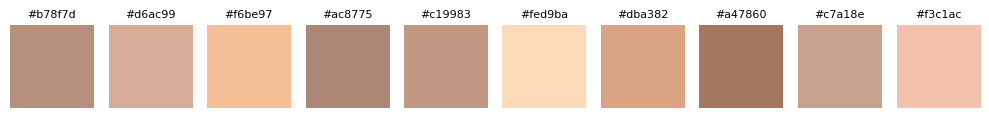

In [45]:
def plot_hex_colors(hex_colors):
    num_colors = len(hex_colors)
    fig, ax = plt.subplots(1, num_colors, figsize=(num_colors, 2))  # Adjust figure size

    for i, color in enumerate(hex_colors):
        # Convert hex to RGB
        rgb_color = color_extraction.HEX2RGB(color)
        rgb_array = [[rgb_color]]  # Wrap it in a list to create a 2D array for imshow
        ax[i].imshow(rgb_array)  # Display the color
        ax[i].axis('off')  # Turn off the axis
        ax[i].set_title(color, fontsize=8, pad=5)  # Add the hex code as the title

    plt.tight_layout()
    plt.show()

# Call the function
plot_hex_colors(labels)


In [63]:
df.head()

,full_image_path,skin tone,skin rgb,skin red,skin green,skin blue,label,brightness,red_ratio,green_ratio,blue_ratio
0,faces/1.jpg,#b49680,"[180, 150, 128]",0.705882,0.588235,0.501961,#b78f7d,0.613506,0.393013,0.327511,0.279476
1,faces/2.jpg,#deae9f,"[222, 174, 159]",0.870588,0.682353,0.623529,#d6ac99,0.731842,0.400000,0.313514,0.286486
2,faces/3.jpg,#fec59f,"[254, 197, 159]",0.996078,0.772549,0.623529,#f6be97,0.822296,0.416393,0.322951,0.260656
3,faces/4.jpg,#b8806a,"[184, 128, 106]",0.721569,0.501961,0.415686,#ac8775,0.557716,0.440191,0.306220,0.253589
4,faces/5.jpg,#c09d88,"[192, 157, 136]",0.752941,0.615686,0.533333,#c19983,0.647262,0.395876,0.323711,0.280412


In [49]:
#add brightness and rgb ratios columns
df['brightness'] = 0.2989 * df['skin red'] + 0.587 * df['skin green'] + 0.114 * df['skin blue']

df['red_ratio'] = df['skin red'] / (df['skin red'] + df['skin green'] + df['skin blue'])
df['green_ratio'] = df['skin green'] / (df['skin red'] + df['skin green'] + df['skin blue'])
df['blue_ratio'] = df['skin blue'] / (df['skin red'] + df['skin green'] + df['skin blue'])

df.head()

,full_image_path,skin tone,skin rgb,skin red,skin green,skin blue,label,brightness,red_ratio,green_ratio,blue_ratio
0,faces/1.jpg,#b49680,"[180, 150, 128]",180,150,128,#b78f7d,156.4440,0.393013,0.327511,0.279476
1,faces/2.jpg,#deae9f,"[222, 174, 159]",222,174,159,#d6ac99,186.6198,0.400000,0.313514,0.286486
2,faces/3.jpg,#fec59f,"[254, 197, 159]",254,197,159,#f6be97,209.6856,0.416393,0.322951,0.260656
3,faces/4.jpg,#b8806a,"[184, 128, 106]",184,128,106,#ac8775,142.2176,0.440191,0.306220,0.253589
4,faces/5.jpg,#c09d88,"[192, 157, 136]",192,157,136,#c19983,165.0518,0.395876,0.323711,0.280412


In [51]:
# Normalize the values to a range between 0 and 1
df['skin red'] = df['skin red'] / 255.0
df['skin green'] = df['skin green'] / 255.0
df['skin blue'] = df['skin blue'] / 255.0
df['brightness'] = df['brightness'] / 255.0
df.head()

,full_image_path,skin tone,skin rgb,skin red,skin green,skin blue,label,brightness,red_ratio,green_ratio,blue_ratio
0,faces/1.jpg,#b49680,"[180, 150, 128]",0.705882,0.588235,0.501961,#b78f7d,0.613506,0.393013,0.327511,0.279476
1,faces/2.jpg,#deae9f,"[222, 174, 159]",0.870588,0.682353,0.623529,#d6ac99,0.731842,0.400000,0.313514,0.286486
2,faces/3.jpg,#fec59f,"[254, 197, 159]",0.996078,0.772549,0.623529,#f6be97,0.822296,0.416393,0.322951,0.260656
3,faces/4.jpg,#b8806a,"[184, 128, 106]",0.721569,0.501961,0.415686,#ac8775,0.557716,0.440191,0.306220,0.253589
4,faces/5.jpg,#c09d88,"[192, 157, 136]",0.752941,0.615686,0.533333,#c19983,0.647262,0.395876,0.323711,0.280412


In [53]:
#Separate input and labels
X = df[['skin red', 'skin green', 'skin blue', 'brightness' , 'red_ratio', 'green_ratio', 'blue_ratio']]
y = df['label']

In [55]:
#use one hot encoding on y
one_hot_encoder = OneHotEncoder(sparse_output=False)

# One-hot encode the target variable
y_onehot = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

print(y_onehot[21])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [57]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

In [61]:

# Initialize the logistic regression model (Base Model)
model = LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs')

# Convert one-hot encoded target back to categorical indices for training
y_train_categorical = np.argmax(y_train, axis=1)

# Train the model
model.fit(X_train, y_train_categorical)

# Predict on the test set
y_pred_categorical = model.predict(X_test)

# Assuming y_test_categorical is the one-hot encoded labels
# Convert y_test_categorical to the correct class labels by using np.argmax
y_test_categorical = np.argmax(y_test, axis=1)

# Get the actual class names (this is based on your original labels in the dataset)
target_names = one_hot_encoder.categories_[0][:len(np.unique(y_test_categorical))]

#logger.info("Base Model Accuracy:", accuracy_score(y_test_categorical, y_pred_categorical))
# Now, use the correct number of target names in classification_report
print("\nClassification Report:\n", classification_report(y_test_categorical, y_pred_categorical, target_names=target_names))
print("Base Model Accuracy:", accuracy_score(y_test_categorical, y_pred_categorical))


Classification Report:
               precision    recall  f1-score   support

     #a47860       0.00      0.00      0.00         3
     #ac8775       0.00      0.00      0.00         3
     #b78f7d       0.26      1.00      0.41         8
     #c19983       0.00      0.00      0.00         3
     #c7a18e       0.00      0.00      0.00         1
     #d6ac99       0.00      0.00      0.00         9
     #dba382       0.00      0.00      0.00         4
     #f3c1ac       0.40      1.00      0.57         4
     #f6be97       0.00      0.00      0.00         4
     #fed9ba       0.00      0.00      0.00         2

    accuracy                           0.29        41
   macro avg       0.07      0.20      0.10        41
weighted avg       0.09      0.29      0.14        41

Base Model Accuracy: 0.2926829268292683


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [73]:
'''
#Hyperparameters to test
criterion_options = ['gini', 'entropy']
max_depth_options = [5, 10, None]
min_samples_split_options = [2, 5, 10]

# Iterate over hyperparameter combinations
for criterion, max_depth, min_samples_split in product(criterion_options, max_depth_options, min_samples_split_options):
    # Initialize and train the model
    tree_model = DecisionTreeClassifier(
        criterion=criterion, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        random_state=42
    )
    tree_model.fit(X_train, y_train)

    # Predict and calculate accuracy
    y_pred = tree_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    logger.info(f"Hyperparameters: Criterion={criterion}, Max Depth={max_depth}, Min Samples Split={min_samples_split}")
    logger.info(f"Accuracy: {accuracy:.4f}")
'''

In [75]:
'''
# Define hyperparameters to tune
n_estimators_options = [50, 100, 200, 500]  
max_depth_options = [10, 20, 30, None]

# Iterate over hyperparameter combinations
for n_estimators, max_depth in product(n_estimators_options, max_depth_options):
    # Initialize and train the model
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=42
    )
    rf_model.fit(X_train, y_train)

    # Predict and calculate accuracy
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    logger.info(f"Hyperparameters: n_estimators={n_estimators}, Max Depth={max_depth}")
    logger.info(f"Accuracy: {accuracy:.4f}")
'''

In [79]:
'''
# Define hyperparameters to tune
n_estimators_options = [50, 100, 200, 500]  # Number of boosting rounds
max_depth_options = [3, 5, 7, 10]           # Maximum depth of trees
learning_rate_options = [0.01, 0.1, 0.2]   # Learning rate

#Iterate over hyperparameter combinations
for n_estimators, max_depth, learning_rate in product(n_estimators_options, max_depth_options, learning_rate_options):
    # Initialize and train the model
    xgb_model = XGBClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate, 
        random_state=42, 
        use_label_encoder=False,  # Prevent deprecation warning
        eval_metric="logloss"     # Evaluation metric for XGBoost
    )
    xgb_model.fit(X_train, y_train)

    # Predict and calculate accuracy
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Log the results
    logger.info(f"Hyperparameters: n_estimators={n_estimators}, Max Depth={max_depth}, Learning Rate={learning_rate}")
    logger.info(f"Accuracy: {accuracy:.4f}")
'''

C:\Users\Izba\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [11:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Izba\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [11:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Izba\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [11:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

In [94]:
#since the best model is random forest with 200 n-estimators with accuracy of 87% use that
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and calculate accuracy
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.8780487804878049


In [98]:
#export this model to use in website
with open('../src/random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)